## FAKE NEWS PREDICTION USING LSTM AND EMBEDDINGS

The motivation to use an Long Short Term Memory model was to evaluate how a deep learning model would do in terms of predicting fake news without performing too much data wrangling. The methodology used was to first get the data in a clean form that can be used to predict, then get word embeddings using Google's word2vec and finally using an LSTM neural network to train the model. Word embeddings are used so that the model can learn context of the sentences from past order of words in the text as well as the future order. LSTM is used to help the model learn from the linguistic context that has been developed progressively becasuse it capable of storing information for extended time periods. Therefore, the model levergaing LSTM is being tested to contrast the with supervised models which do not the context of previous inputs into account.

In [25]:
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow import keras
from keras import regularizers, initializers, optimizers, callbacks
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import *
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D

import pandas as pd
import numpy as np

import word2vec
import nltk
import gensim


In [26]:
df = pd.read_csv('lstm_data.csv')
df.head()

,Unnamed: 0,title_text,label
0,0,house dem aide we didn’t even see comey’s lett...,1
1,1,flynn hillary clinton big woman on campus bre...,0
2,2,why the truth might get you fired october twen...,1
3,3,fifteen civilians killed in single us airstrik...,1
4,4,iranian woman jailed for fictional unpublished...,1


In [27]:
#defining constants 
MAX_NB_WORDS = 1000000      # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000  # max length of each sentence, including padding
VALIDATION_SPLIT = 0.2      # 20% of data for validation 
EMBEDDING_DIM = 100          # embedding dimensions for word vectors

In [28]:
# removing stop words and performing some cleaning
stop_words = set(stopwords.words('english'))

def stop_words_remove(data):
    '''
    Function to remove stop words. 

    Inputs:
        text (str): A string of text
    
    Outputs:
        processed text (str): A string of processed text
    '''
    
    # creating tokens
    data = nltk.word_tokenize(data)
    
    # remove stopwords
    data = [ele for ele in data if ele not in stop_words]

    data = ' '.join(data)
    
    return data

df['title_text'] = df['title_text'].astype(str).apply(stop_words_remove)

df['title_text'] = df['title_text'].astype(str).apply(lambda x: re.sub(r"[\’]+", "", x))
df['title_text'] = df['title_text'].astype(str).apply(lambda x: re.sub(r'\s+', ' ', x).strip())

**One-Hot Encoding:** It is a technique that creates a vector representation of unique words or a vocabulary. For a vocabulary of size n, an n-sized vector is created which represents a word with binary values 1 and 0. Here, hot encoded label is created which has two values corresponding to 0 and 1 depending on the label as we only have binary class in this case.

In [29]:
#creating text variable and hot encoded label
x = df['title_text'].tolist()
y = pd.get_dummies(df['label'])
y = np.array(y)

**Tokenization:** Through this process each unique word in the data is associated with an integer and stored in a dictionary. Further, a representation sequence of text in each row is created using the assigned unique integer values based on the dictionary.

In [30]:
#tokenization
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index
print('Vocabulary size is:', len(word_index))

Vocabulary size is: 156318


In [31]:
# dictionary representation of each unique word in the data
print(word_index)

{'“': 1, '”': 2, 'said': 3, 'one': 4, 'mr': 5, 'two': 6, 'trump': 7, 'thousand': 8, '—': 9, 'hundred': 10, 'would': 11, 'new': 12, 'people': 13, 'clinton': 14, 'us': 15, 'like': 16, 'also': 17, 'president': 18, 'time': 19, 'state': 20, 'nine': 21, 'could': 22, 'many': 23, 'even': 24, 'years': 25, 'states': 26, 'first': 27, 'government': 28, 'times': 29, 'world': 30, 'american': 31, 'three': 32, 'hillary': 33, 'news': 34, 'last': 35, 'united': 36, 'obama': 37, 'york': 38, 'year': 39, 'get': 40, 'may': 41, '‘': 42, 'campaign': 43, 'election': 44, 'country': 45, 'ms': 46, 'going': 47, 'make': 48, 'way': 49, 'house': 50, 'sixteen': 51, 'made': 52, 'white': 53, 'know': 54, 'back': 55, 'media': 56, 'much': 57, 'think': 58, 'day': 59, 'four': 60, 'say': 61, 'political': 62, 'five': 63, 'war': 64, 'see': 65, 'donald': 66, 'still': 67, 'national': 68, 'russia': 69, 'told': 70, 'since': 71, 'public': 72, 'well': 73, 'take': 74, '–': 75, 'police': 76, 'according': 77, 'want': 78, 'work': 79, 'ano

**PADDING:** The process of adding zeroes at the end or beginning so that all sequences are of same length.

In [32]:
#padding
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Data tensor shape:', data.shape)
print('Label tensor shape:', y.shape)

Data tensor shape: (20168, 1000)
Label tensor shape: (20168, 2)


In [33]:
#random shuffling data and labels
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [34]:
# tokenized and padded data representation and hot encoded label
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [   944   4725   1612    228   3121     89    244   1560     12     38
     29   4725      9      4    123    524   1586  12641  22310   4033
     55   1612      4    325   1612   2552    503    738   3435    116
    144   6503   2964   3550    542   1586    938    524    395    696
    395   2000    228    333    217   4725  24429   1612    357   1543
     13   2176      6     10     92      3    332    331   3619    228
   5537   3190    987    944    301  21975    180   1545    713     77
   1586    353    848   1770   3562   4583   1397    228   1227    944
   4142  12372    244   1560   4725    343   1612    156     30  12735
   6537   1932    531   3037   7169    440    447    435   1317    763
     39    156    944     63   4157      6   7524      4   2120    166
    506   2790   8454    999  14946   1586    353      3    462    228
      9    858    101    549   1586     92      3   2661     79    350
     20      9   1447    212   4213   8540    450    5

In [35]:
#splitting into train and validation data
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Entries in training set: ', y_train.sum(axis=0))
print('Entries in validation set: ', y_val.sum(axis=0))

Entries in training set:  [8324 7811]
Entries in validation set:  [2060 1973]


**EMBEDDINGS:** Word embeddings are vector representations of words that occur in a corpus. Words that have similar meanings have the same representation so that a computer can understand the context of the sequences of words. It creates an approximation of meaning that can be represented in a lower dimensional space as a signal to a machine learning model of what the underlying meaning of data could be. Using word embeddings each word is represented as a real-valued vector with tens or hundreds of dimensions.

word2vec: Google developed model to train word embeddings based on a distributional hypothesis. It uses skip-grams or a continuous bag of words to learn associations between words. Based on the assumption that in a text, neighboring words have semantic similarities, it maps them to gemoterically close embedding vectors.  

In [36]:
# Load Google news word2vec vectors
filename = '/home/ridhi/Documents/GoogleNews-vectors-negative300.bin'

# loading vectors
word2vec = gensim.models.KeyedVectors.load_word2vec_format(filename, binary=True)

In [37]:
EMBEDDING_DIM = 300

# get word index of Keras tokenizer
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

emb_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in word2vec.key_to_index:
        emb_matrix[i] = word2vec.get_vector(word)
print('Null word embeddings: %d' % np.sum(np.sum(emb_matrix, axis=1) == 0))

Null word embeddings: 87760


**Long Short-Term Memory:**  LSTM is a type of Recurrent Neural Network that is capable of processing sequential data and handles long-term dependcies by preventing the vanishing gradient problem. It consists of memory cells capable of storing information and 'forgetting' or 'remembering' the information depending on the context. LSTM network leverages backpropagation for training through time, and calculates gradients for all the time steps and updates network weights based on an optimization algorithm. 

In [38]:
#defining neural network with non-trainable embedding layer
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[emb_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

2023-05-21 11:12:48.518591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 11:12:48.520002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 11:12:48.521261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 300)         46895700  
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 47,140,246
Trainable params: 244,546
Non-trainable params: 46,895,700
_________________________________________________________________


Epoch 1/6


2023-05-21 11:12:50.210399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 11:12:50.212544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 11:12:50.213781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

127/127 [==============================] - ETA: 0s - loss: 0.6811 - acc: 0.5313

2023-05-21 11:16:22.787128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 11:16:22.789379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 11:16:22.790950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

127/127 [==============================] - 237s 2s/step - loss: 0.6811 - acc: 0.5313 - val_loss: 0.6751 - val_acc: 0.5113
Epoch 2/6
127/127 [==============================] - 233s 2s/step - loss: 0.6720 - acc: 0.5289 - val_loss: 0.6690 - val_acc: 0.5376
Epoch 3/6
127/127 [==============================] - 238s 2s/step - loss: 0.6652 - acc: 0.5394 - val_loss: 0.6679 - val_acc: 0.5383
Epoch 4/6
127/127 [==============================] - 231s 2s/step - loss: 0.6634 - acc: 0.5397 - val_loss: 0.6704 - val_acc: 0.5353
Epoch 5/6
127/127 [==============================] - 232s 2s/step - loss: 0.6565 - acc: 0.5437 - val_loss: 0.6702 - val_acc: 0.5391
Epoch 6/6
127/127 [==============================] - 234s 2s/step - loss: 0.6512 - acc: 0.5478 - val_loss: 0.6718 - val_acc: 0.5376
For number of epochs 6


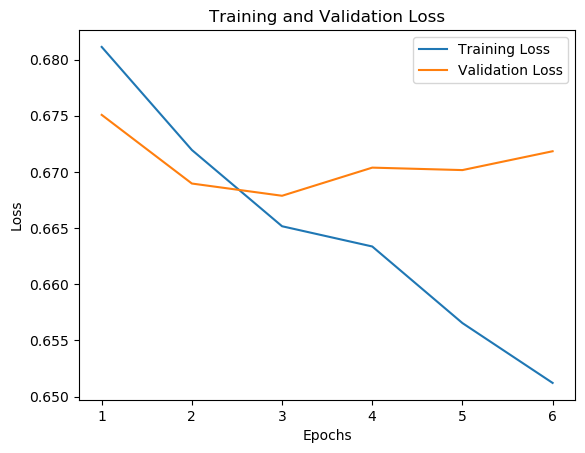

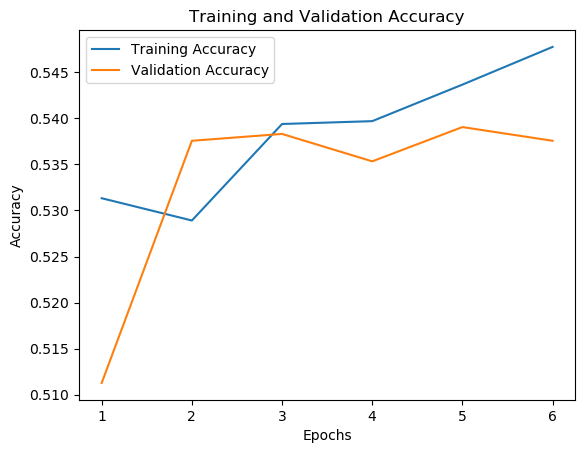

Epoch 1/10
127/127 [==============================] - 239s 2s/step - loss: 0.6529 - acc: 0.5437 - val_loss: 0.6794 - val_acc: 0.5361
Epoch 2/10
127/127 [==============================] - 246s 2s/step - loss: 0.6505 - acc: 0.5461 - val_loss: 0.6855 - val_acc: 0.5378
Epoch 3/10
127/127 [==============================] - 234s 2s/step - loss: 0.6459 - acc: 0.5479 - val_loss: 0.6926 - val_acc: 0.5383
Epoch 4/10
127/127 [==============================] - 233s 2s/step - loss: 0.6462 - acc: 0.5480 - val_loss: 0.6921 - val_acc: 0.5395
Epoch 5/10
127/127 [==============================] - 248s 2s/step - loss: 0.6475 - acc: 0.5479 - val_loss: 0.6901 - val_acc: 0.5381
Epoch 6/10
127/127 [==============================] - 306s 2s/step - loss: 0.6449 - acc: 0.5482 - val_loss: 0.6861 - val_acc: 0.5373
Epoch 7/10
127/127 [==============================] - 308s 2s/step - loss: 0.6435 - acc: 0.5489 - val_loss: 0.6858 - val_acc: 0.5398
Epoch 8/10
127/127 [==============================] - 321s 3s/step - 

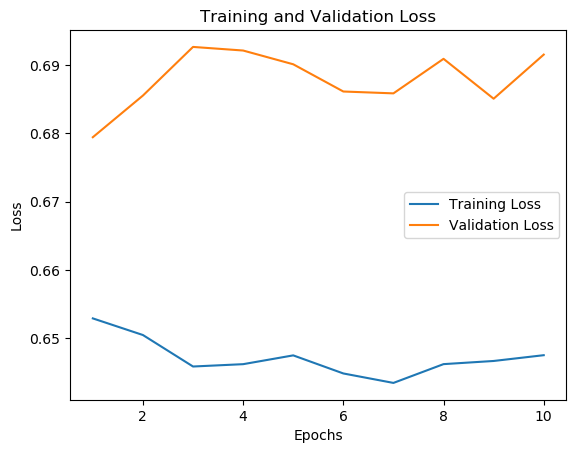

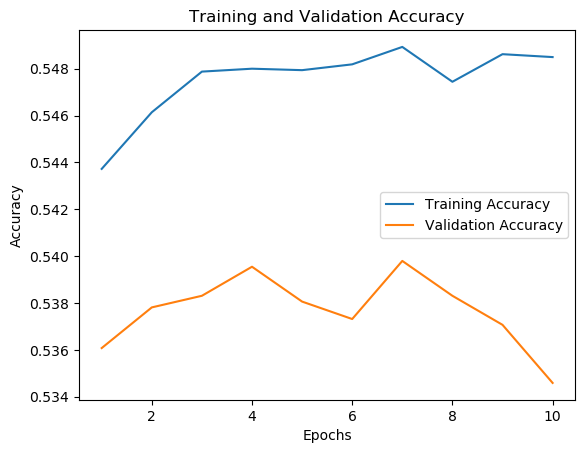

Epoch 1/12
127/127 [==============================] - 234s 2s/step - loss: 0.6459 - acc: 0.5459 - val_loss: 0.7014 - val_acc: 0.5361
Epoch 2/12
127/127 [==============================] - 236s 2s/step - loss: 0.6440 - acc: 0.5476 - val_loss: 0.6964 - val_acc: 0.5378
Epoch 3/12
127/127 [==============================] - 238s 2s/step - loss: 0.6436 - acc: 0.5487 - val_loss: 0.7057 - val_acc: 0.5358
Epoch 4/12
127/127 [==============================] - 236s 2s/step - loss: 0.6430 - acc: 0.5476 - val_loss: 0.7068 - val_acc: 0.5175
Epoch 5/12
127/127 [==============================] - 235s 2s/step - loss: 0.6473 - acc: 0.5457 - val_loss: 0.6935 - val_acc: 0.5368
Epoch 6/12
127/127 [==============================] - 234s 2s/step - loss: 0.6440 - acc: 0.5483 - val_loss: 0.6969 - val_acc: 0.5348
Epoch 7/12
127/127 [==============================] - 234s 2s/step - loss: 0.6431 - acc: 0.5486 - val_loss: 0.7076 - val_acc: 0.5366
Epoch 8/12
127/127 [==============================] - 234s 2s/step - 

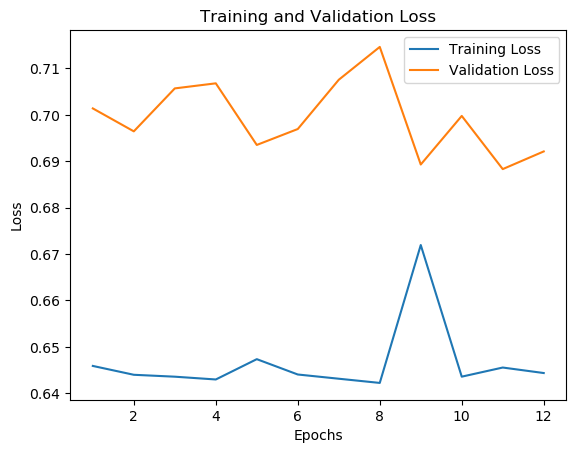

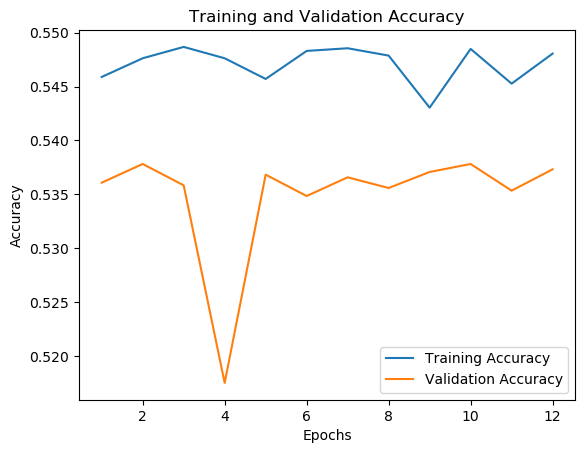

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline


for epoch in [6, 10, 12]:
    history = model.fit(x_train, y_train, epochs = epoch, batch_size=128, validation_data=(x_val, y_val))
    
    print(f"For number of epochs {epoch}")

    #Training and Validation loss plot
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss)+1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show();

    #Training and Validation accuracy plot

    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show();

**Next Steps:** Re-running the LSTM model by finetuning the hyperparameters could be done to see changes in accuracy. This could be helpful for evaluating performance and finding a good accuracy score for the model predicting fake news.

* run for more epochs
* run to a point where validation loss keeps decreasing - increase epochs OR stop when validation loss starts increasing 

* Maybe check for different learning rate
* maybe a better system/cloud could have led to better results
* limitations and what you would do if there were more time and resources 
* neural model may take longer than a simple model like a logistic one 